<h1>SARL Complete Training (IL + RL)</h1>

Import the necessary packages

In [1]:
from jax import random, device_get
import jax.numpy as jnp
import optax
import numpy as np
import time
import matplotlib.pyplot as plt

from socialjym.envs.socialnav import SocialNav
from socialjym.policies.sarl import SARL
from socialjym.utils.replay_buffers.uniform_vnet_replay_buffer import UniformVNetReplayBuffer
from socialjym.utils.rollouts.deep_vnet_rollouts import deep_vnet_rl_rollout, deep_vnet_il_rollout
from socialjym.utils.aux_functions import epsilon_scaling_decay, plot_state, plot_trajectory, test_k_trials
from socialjym.utils.rewards.reward1 import generate_reward_done_function

/home/tommasovan/PyVenvs/socialjym/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the training hyperparameters

In [2]:
random_seed = 1
il_training_episodes = 3_000
il_learning_rate = 0.001 # For SARL this has to be lower than for CADRL
il_num_epochs = 50 # Number of epochs to train the model after ending IL
rl_training_episodes = 10_000
rl_learning_rate = 0.001 # For SARL this has to be lower than for CADRL
rl_num_batches = 100 # Number of batches to train the model after each RL episode
batch_size = 100 # Number of experiences to sample from the replay buffer for each model update
epsilon_start = 0.5
epsilon_end = 0.1
epsilon_decay = 4_000
buffer_size = 100_000 # Maximum number of experiences to store in the replay buffer (after exceeding this limit, the oldest experiences are overwritten with new ones)
target_update_interval = 50 # Number of episodes to wait before updating the target network for RL (the one used to compute the target state values)
humans_policy = 'sfm'
scenario = 'hybrid_scenario'

Set the reward and environment parameters

In [3]:
# Reward function parameters
reward_params = {
    'goal_reward': 1.,
    'collision_penalty': -0.25,
    'discomfort_distance': 0.2,
    'time_limit': 50.,
}

# Initialize reward function
reward_function = generate_reward_done_function(**reward_params)

# Environment parameters
env_params = {
    'robot_radius': 0.3,
    'n_humans': 5, # SARL can be trained with multiple humans
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': False,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}

Initialize environment, robot policy and replay buffer

In [4]:
# Initialize environment
env = SocialNav(**env_params)

# Initialize robot policy and vnet params
policy = SARL(env.reward_function, dt=env_params['robot_dt'])
initial_vnet_params = policy.model.init(random.key(random_seed), jnp.zeros((env.n_humans, policy.vnet_input_size,)))

# Initialize replay buffer
replay_buffer = UniformVNetReplayBuffer(buffer_size, batch_size)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<h2>Imitation Learning</h2>

Initialize the optimizer and the buffer state dictionary (where experiences will be stored)

In [5]:
# Initialize IL optimizer
optimizer = optax.sgd(learning_rate=il_learning_rate, momentum=0.9)

# Initialize buffer state
buffer_state = {
    'vnet_inputs': jnp.empty((buffer_size, env.n_humans, policy.vnet_input_size)),
    'targets': jnp.empty((buffer_size,1)),
}

Set all the parameters for the imitation learning rollout

In [6]:
il_rollout_params = {
    'initial_vnet_params': initial_vnet_params,
    'train_episodes': il_training_episodes,
    'random_seed': random_seed,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': 0,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_epochs': il_num_epochs,
    'batch_size': batch_size,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

During imitation learning, the robot will move using the same policy used by humans. Let's start the rollout.

In [7]:
il_out = deep_vnet_il_rollout(**il_rollout_params)

Simulating IL episodes...


Running for 3,000 iterations: 100%|████████| 3000/3000 [00:23<00:00, 127.89it/s]


Buffer size after IL: 100000
Optimizing model on generated experiences for 50 epochs...


Running for 50 iterations: 100%|████████████████| 50/50 [07:24<00:00,  8.90s/it]


Now, we save the parameters we are interested in from the rollout output and we plot the discounted return over the IL training episodes and the loss over the optimization epochs.

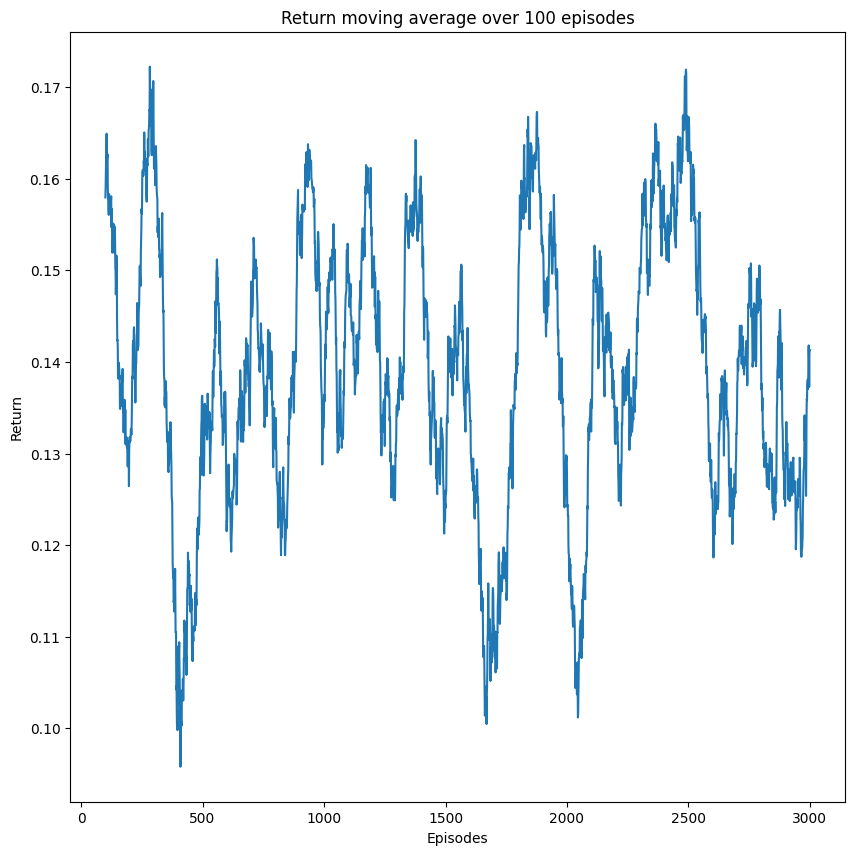

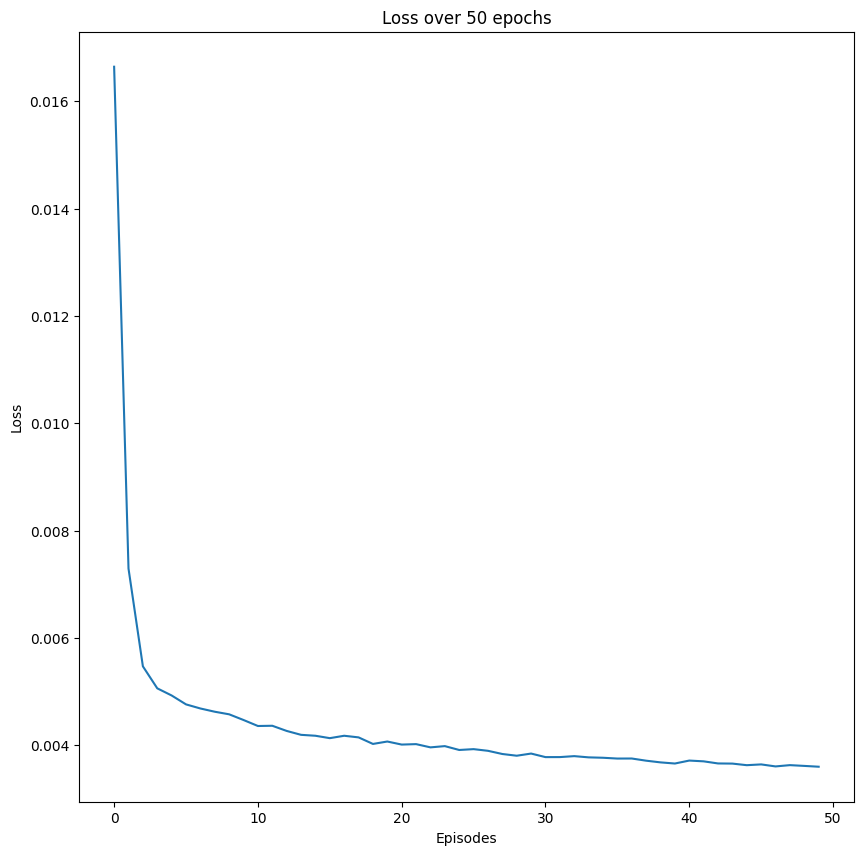

In [8]:
# Save the IL model parameters, buffer state, and keys
il_model_params = il_out['model_params']
reset_key = il_out['reset_key']
policy_key = il_out['policy_key']
buffer_state = il_out['buffer_state']
current_buffer_size = il_out['current_buffer_size']

# Plot the losses and returns
window = 100
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(il_out['returns'])-(window-1))+window, jnp.convolve(il_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss over {} epochs'.format(len(il_out['losses'])))
ax.plot(np.arange(len(il_out['losses'])), il_out['losses'])
plt.show()

Let's test the IL trained agent on 1000 unseen trials. The robot is still NOT visible by humans here.

In [9]:
test_k_trials(1000, 2, env, policy, il_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])

Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [01:59<00:00,  8.40it/s]


RESULTS
Success rate: 0.81
Collision rate: 0.07
Timeout rate: 0.12
Average return: 0.02
Average time to goal: 17.73


{'collisions': Array(70, dtype=int32, weak_type=True),
 'returns': Array([ 5.37315421e-02, -3.10660660e-01, -4.00629193e-01,  1.72489703e-01,
         1.90573215e-01,  1.64316326e-01,  0.00000000e+00,  0.00000000e+00,
         1.25730917e-01,  1.38301492e-01,  1.80484787e-01, -2.28567421e-03,
        -2.98509538e-01, -3.65597844e-01,  1.95325404e-01, -2.36039922e-01,
         0.00000000e+00,  0.00000000e+00,  1.80282116e-01,  1.66771740e-01,
         1.90628722e-01, -9.77818519e-02, -5.57374477e-01, -2.49386966e-01,
         8.78472030e-02, -2.34152332e-01,  1.85301945e-01,  1.71222895e-01,
         7.97663927e-02,  1.78406388e-01,  1.40407607e-01,  1.21576592e-01,
         1.16450392e-01, -3.16039503e-01,  1.54100597e-01,  3.13808918e-02,
         1.01105392e-01,  1.51133567e-01,  1.90247670e-01, -4.49337065e-04,
        -1.36891887e-01,  3.58460099e-02, -1.22780129e-01,  0.00000000e+00,
         1.18644007e-01,  1.54100597e-01,  0.00000000e+00, -3.80093634e-01,
        -7.26041570e-0

<h2>Reinforcement Learning</h2>

Initialize the optimizer and the next rollout parameters. We should start from the model parameters compute after IL.

In [10]:
# Initialize RL optimizer
optimizer = optax.sgd(learning_rate=rl_learning_rate, momentum=0.9)

# Initialize RL rollout params
rl_rollout_params = {
    'initial_vnet_params': il_model_params,
    'train_episodes': rl_training_episodes,
    'random_seed': random_seed,
    'model': policy.model,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': current_buffer_size,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_batches': rl_num_batches,
    'epsilon_decay_fn': epsilon_scaling_decay,
    'epsilon_start': epsilon_start,
    'epsilon_end': epsilon_end,
    'decay_rate': epsilon_decay,
    'target_update_interval': target_update_interval,
    'success_reward': reward_params['goal_reward'],
    'failure_reward': reward_params['collision_penalty']
}

Let's start the RL rollout.

In [11]:
rl_out = deep_vnet_rl_rollout(**rl_rollout_params)

Running for 10,000 iterations: 100%|████| 10000/10000 [2:52:29<00:00,  1.03s/it]


Save the final model parameters and plot discounted return and loss over the RL training episodes.

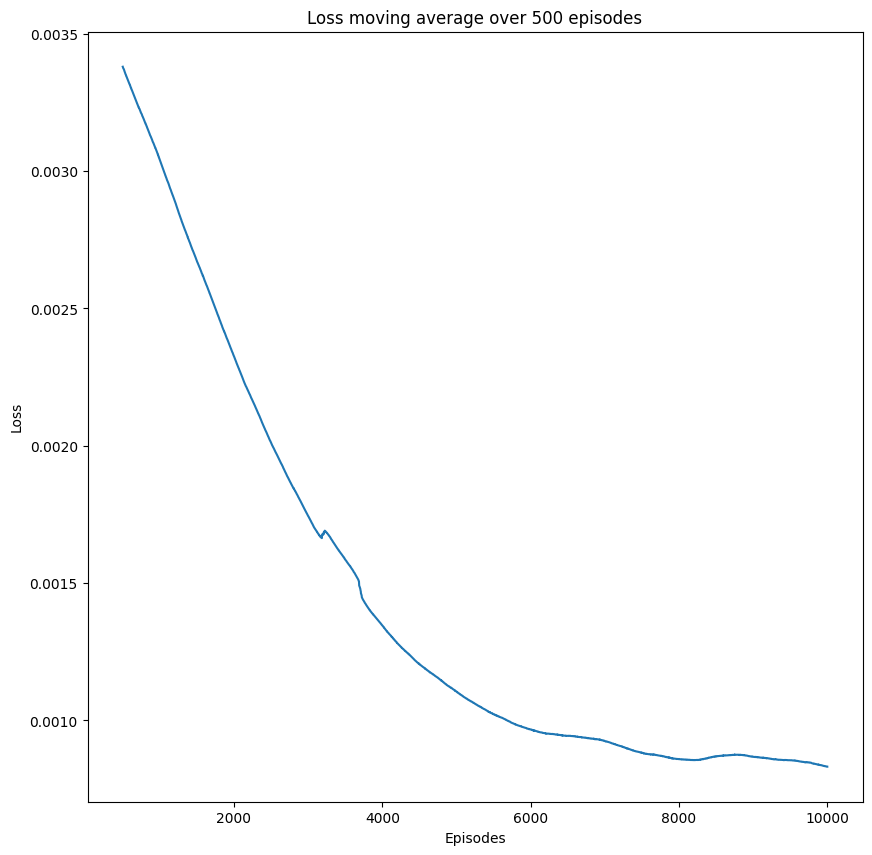

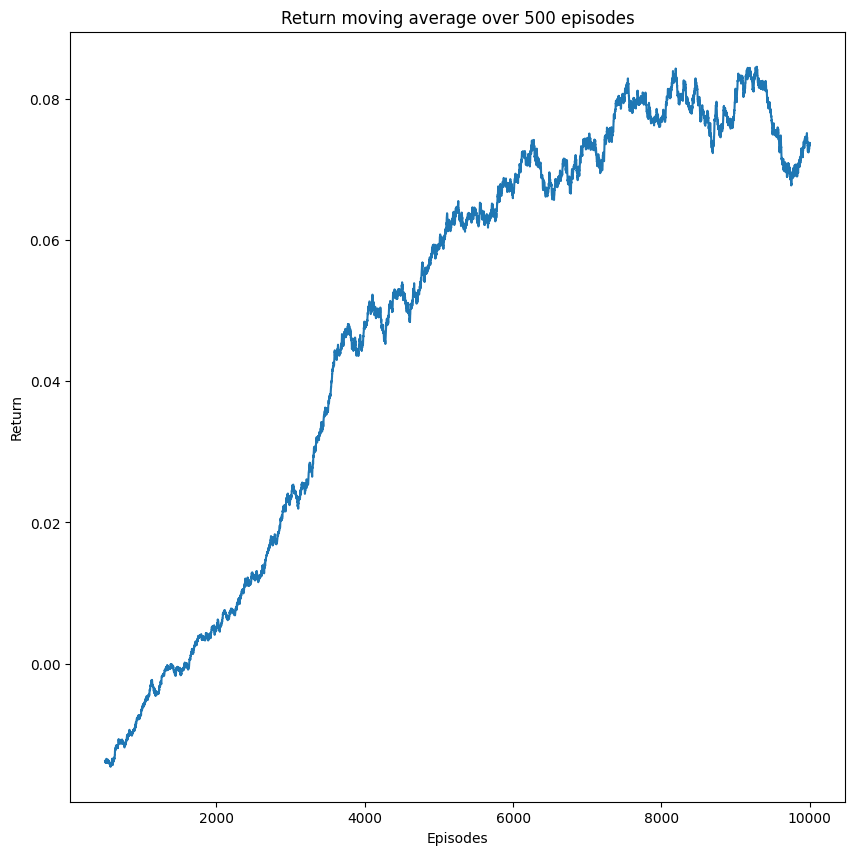

In [12]:
# Save the final model parameters and keys
final_model_params = rl_out['model_params']
reset_key = rl_out['reset_key']
policy_key = rl_out['policy_key']

figure, ax = plt.subplots(figsize=(10,10))
window = 500
ax.plot(np.arange(len(rl_out['losses'])-(window-1))+window, jnp.convolve(rl_out['losses'], jnp.ones(window,), 'valid') / window)
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss moving average over {} episodes'.format(window))
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(rl_out['returns'])-(window-1))+window, jnp.convolve(rl_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()

Let's test the RL trained agent in three environments, with 1, 5 and 10 humans. In all environmentss the robot is NOT visible.

In [13]:
env_params = {
    'robot_radius': 0.3,
    'n_humans': 5,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env = SocialNav(**env_params)
env10_params = {
    'robot_radius': 0.3,
    'n_humans': 10,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env10 = SocialNav(**env10_params)
env15_params = {
    'robot_radius': 0.3,
    'n_humans': 15,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
    'time_limit': reward_params['time_limit'],
}
env15 = SocialNav(**env15_params)
test_k_trials(1000, 3, env, policy, final_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])
test_k_trials(1000, 3, env10, policy, final_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])
test_k_trials(1000, 3, env15, policy, final_model_params, success_reward=reward_params['goal_reward'], failure_reward=reward_params['collision_penalty'])

Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [01:44<00:00,  9.53it/s]



RESULTS
Success rate: 0.98
Collision rate: 0.00
Timeout rate: 0.02
Average return: 0.18
Average time to goal: 16.51
Executing 1000 tests with 10 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [03:36<00:00,  4.62it/s]



RESULTS
Success rate: 0.97
Collision rate: 0.00
Timeout rate: 0.03
Average return: 0.16
Average time to goal: 16.86
Executing 1000 tests with 15 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [05:15<00:00,  3.17it/s]


RESULTS
Success rate: 0.96
Collision rate: 0.00
Timeout rate: 0.04
Average return: 0.14
Average time to goal: 17.36


{'collisions': Array(0, dtype=int32, weak_type=True),
 'returns': Array([ 0.12167497,  0.04751869,  0.1697217 ,  0.16634363,  0.1468867 ,
         0.12799144,  0.14375998,  0.13942453,  0.10941893,  0.16553043,
         0.13734488,  0.14459129,  0.15315053,  0.15360536,  0.16143982,
         0.05995382,  0.12139501,  0.16827735,  0.14469688,  0.18152432,
         0.13072254,  0.1319443 ,  0.11017642,  0.13884746,  0.12551408,
         0.16840379,  0.12883839,  0.04435065,  0.17108281,  0.12453402,
         0.14912291,  0.13509485,  0.15671591,  0.15194176,  0.13452165,
         0.14263567,  0.05129085,  0.1636913 ,  0.15776254,  0.14207372,
         0.13392878,  0.05833679,  0.17714149,  0.14082275,  0.13385159,
         0.15239312,  0.15089786,  0.17165244,  0.04842681,  0.15698239,
         0.14281763,  0.1735479 ,  0.14638484,  0.17038794,  0.18127711,
         0.19346961,  0.10592537,  0.17270085,  0.10106056,  0.1759665 ,
         0.10625587,  0.11521261,  0.16921262,  0.15682794,

Simulate some episodes using the trained agent.

Episode 0 ended - Execution time 2.02 seconds - Plotting trajectory...


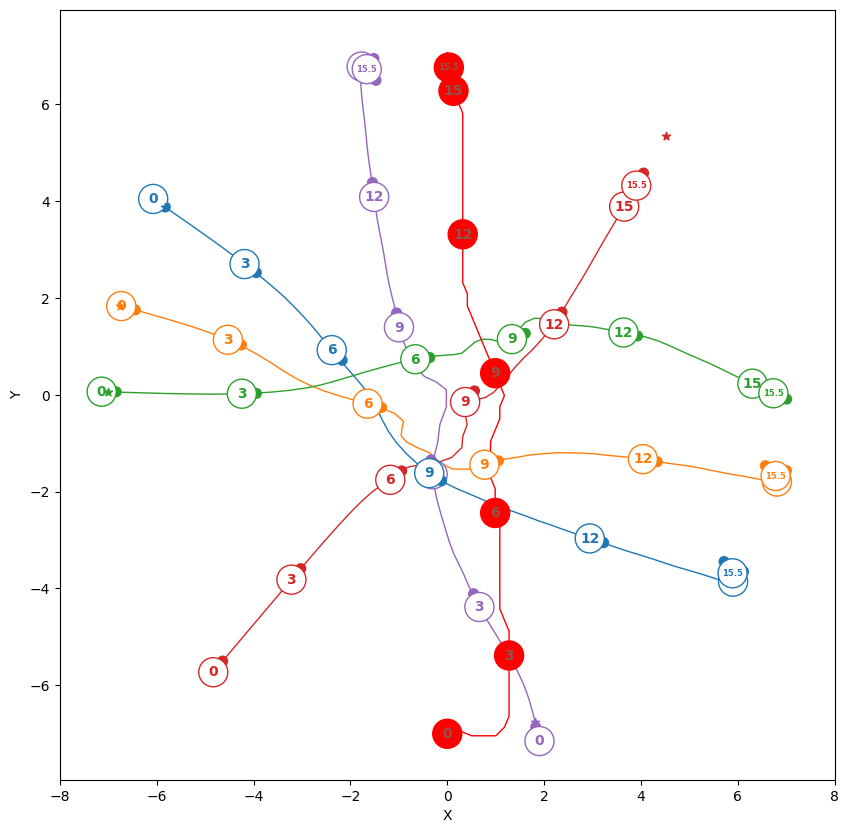

Episode 1 ended - Execution time 0.12 seconds - Plotting trajectory...


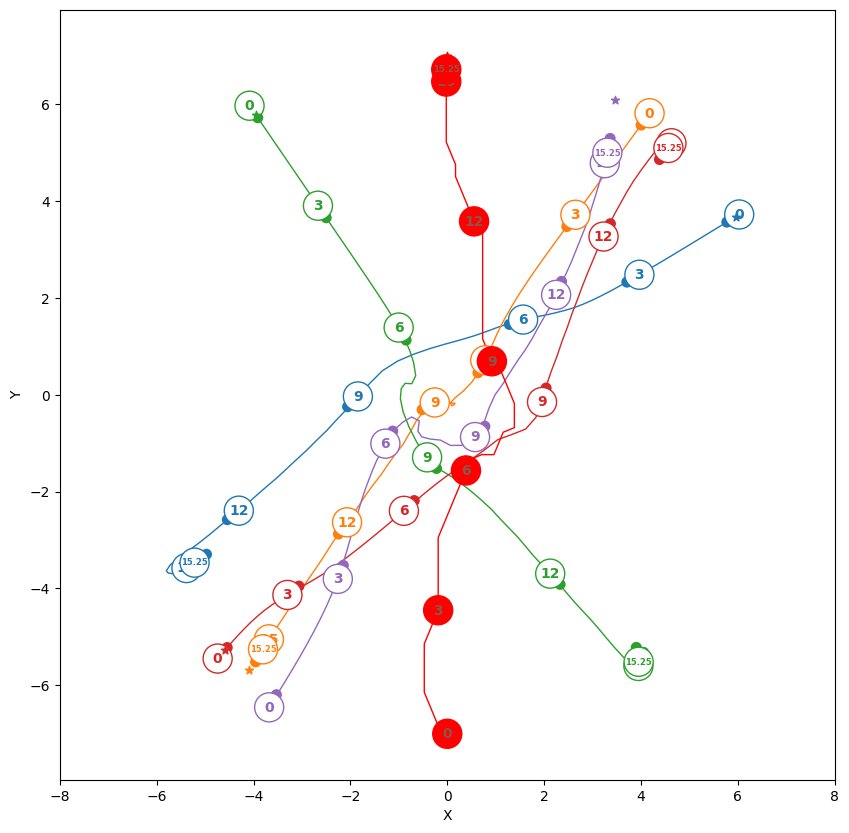

Episode 2 ended - Execution time 0.13 seconds - Plotting trajectory...


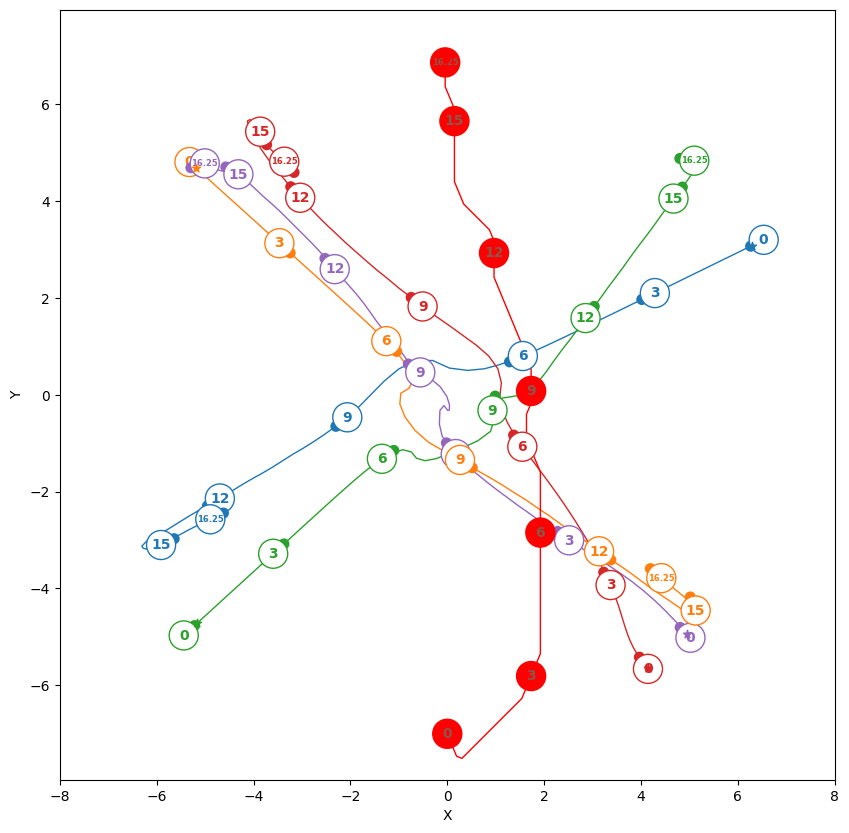

Episode 3 ended - Execution time 0.11 seconds - Plotting trajectory...


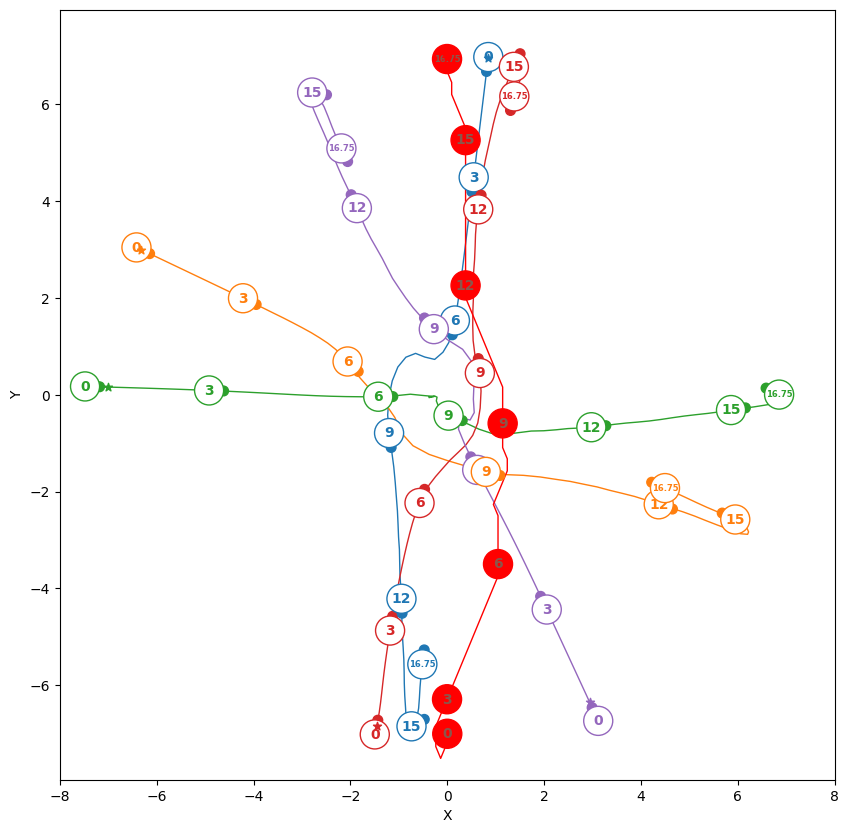

Episode 4 ended - Execution time 0.13 seconds - Plotting trajectory...


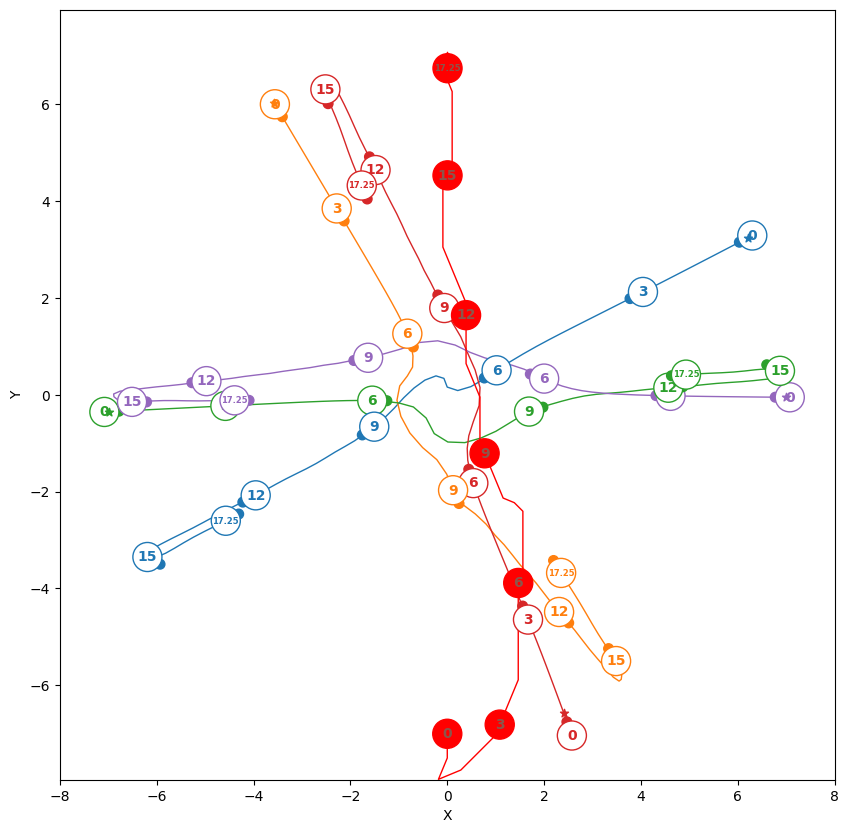

Average time per episode: 0.5 seconds
Total time for 5 episodes: 2.51 seconds


In [14]:
n_episodes = 5
env = SocialNav(**env_params)
# Simulate some episodes
episode_simulation_times = np.empty((n_episodes,))
for i in range(n_episodes):
    done = False
    episode_start_time = time.time()
    state, reset_key, obs, info = env.reset(reset_key)
    all_states = np.array([state])
    while not done:
        # action = jnp.array([0.,1.]) # Move north
        action, policy_key, _ = policy.act(policy_key, obs, info, final_model_params, 0.)
        state, obs, info, reward, done = env.step(state,info,action) 
        all_states = np.vstack((all_states, [state]))
    episode_simulation_times[i] = round(time.time() - episode_start_time,2)
    all_states = device_get(all_states) # Transfer data from GPU to CPU for plotting
    print(f"Episode {i} ended - Execution time {episode_simulation_times[i]} seconds - Plotting trajectory...")
    ## Plot episode trajectory
    figure, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    plot_trajectory(ax, all_states, info['humans_goal'], info['robot_goal'])
    for k in range(0,len(all_states),int(3/env_params['robot_dt'])):
        plot_state(ax, k*env_params['robot_dt'], all_states[k], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    # plot last state
    plot_state(ax, (len(all_states)-1)*env_params['robot_dt'], all_states[len(all_states)-1], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    plt.show()
# Print simulation times
print(f"Average time per episode: {round(np.mean(episode_simulation_times),2)} seconds")
print(f"Total time for {n_episodes} episodes: {round(np.sum(episode_simulation_times),2)} seconds")